v2. This time output center point of ROI instead of upper left corner.

v3. Center x, y, w and h values around mean

v4. Don't center around mean, but center each ROI in the middle of it's cell by default. Use mean h and w as defaults.

v5. Normalize x, y to offset within grid cell, w, h to percentage of overall image size

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import csv
import pickle
import os
import pydicom
%matplotlib inline

In [2]:
GRID_SIZE = 4
location_data = np.zeros((GRID_SIZE,GRID_SIZE,5))

for i in range(4):
    for j in range(4):
        location_data[i,j,:] = [0, 390, 365, 225, 335]

In [3]:
img = pydicom.dcmread(os.path.join("stage_1_train_images", "fffb2395-8edd-4954-8a89-ffe2fd329be3.dcm")).pixel_array

  1. , 289.5, 549.5, 225. , 529.
  1. , 741.5, 627.5, 201. , 309.

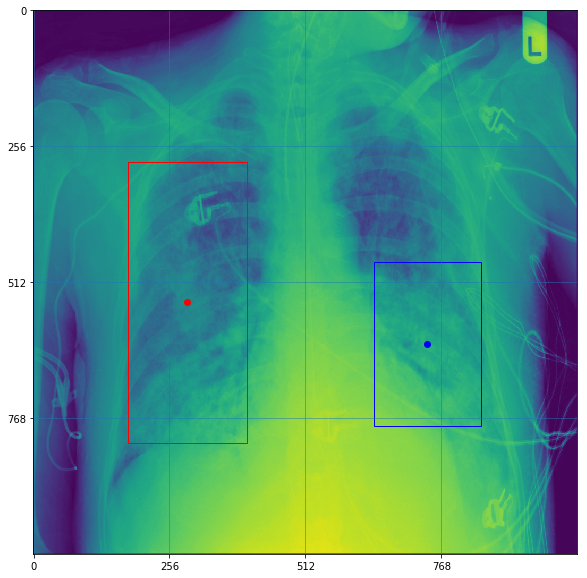

In [4]:
coords = np.arange(0, 1024, 256)

fig,ax = plt.subplots(1, figsize=(10,10))
plt.imshow(img)
rect_1 = patches.Rectangle((177,285),225,529,linewidth=1,edgecolor='r',facecolor='none')
plt.plot(289.5, 549.5, marker="o", color="r")

rect_2 = patches.Rectangle((641,473),201,309,linewidth=1,edgecolor='b',facecolor='none')
plt.plot(741.5, 627.5, marker="o", color="b")

ax.add_patch(rect_1)
ax.add_patch(rect_2)

plt.xticks(coords)
plt.yticks(coords)
for item in coords:
    plt.axvline(item, linewidth=0.5)
    plt.axhline(item, linewidth=0.5)
# plt.xlim(0,1024)
# plt.ylim(0,1024)
plt.show()

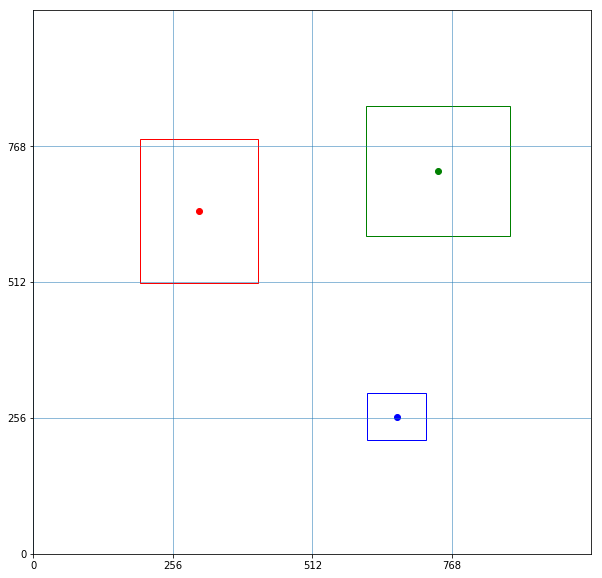

In [5]:
coords = np.arange(0, 1024, 256)

fig,ax = plt.subplots(1, figsize=(10,10))

rect_1 = patches.Rectangle((195,511),218,271,linewidth=1,edgecolor='r',facecolor='none')
plt.plot(304, 646.5, marker="o", color="r")
rect_2 = patches.Rectangle((612,214),109,89,linewidth=1,edgecolor='b',facecolor='none')
plt.plot(666.5, 258.5, marker="o", color="b")
rect_3 = patches.Rectangle((610,599),265,245,linewidth=1,edgecolor='g',facecolor='none')
plt.plot(742.5, 721.5, marker="o", color="g")
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
plt.xticks(coords)
plt.yticks(coords)
for item in coords:
    plt.axvline(item, linewidth=0.5)
    plt.axhline(item, linewidth=0.5)
plt.xlim(0,1024)
plt.ylim(0,1024)
plt.show()

In [6]:
boxes = [
    [195,511,218,271],
    [612,214,109,89],
    [610,599,265,245]
]

centers = []

for box in boxes:
    x,y,w,h = box
    center_x = x + (w / 2)
    center_y = y + (h / 2)
    centers.append((center_x,center_y))

pixel_locs = []    
for center in centers:
    x_pixel = center[0] // 64
    y_pixel = center[1] // 64
    
    pixel_locs.append((x_pixel,y_pixel))
    
pixel_locs    

[(4.0, 10.0), (10.0, 4.0), (11.0, 11.0)]

In [7]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [9]:
GRID_SIZE = 4
CELL_WIDTH = 1024 // GRID_SIZE

# means to center data
mu_x = 391.456158
mu_y = 363.1358768
mu_w = 220.8453815
mu_h = 334.1743641
mu_center_x = 501.8788487
mu_center_y = 530.2230589


# empty dictionary
pneumonia_locations = {}
used_filenames = []
pixel_means = []
locations = []

# load table
with open(os.path.join('./stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        
        # initialize our data
        if filename not in used_filenames:
            location_data = np.zeros((GRID_SIZE,GRID_SIZE,5))
            
            # default label to mean values
            for i in range(4):
                for j in range(4):
                    y = ((i + 0.5) * CELL_WIDTH)
                    x = ((j + 0.5) * CELL_WIDTH)
                    location_data[i,j,:] = [0, 0.5, 0.5, 0.2, 0.2]
            
            used_filenames.append(filename)
            locs = np.zeros((GRID_SIZE, GRID_SIZE))
        else:
            location_data = pneumonia_locations[filename]
            
        # if row contains pneumonia add label to dictionary
        # the dictionary will contain the presence, x, y, h, w of the pneumonia for each pixel in a 16x16 grid
        if pneumonia == '1':
            # extract the location and cast them to floats
            x,y,w,h = location
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)
            
            # figure out the center of the ROI
            center_x = x + (w / 2)
            center_y = y + (h / 2)
            
            # figure out which pixel is in the center
            x_pixel = int(center_x // (1024 // GRID_SIZE))
            y_pixel = int(center_y // (1024 // GRID_SIZE))
            locs[y_pixel, x_pixel] = 1
            
            ## normalize the data
            # h, w divided by overall image size
            w = w / 1024
            h = h / 1024
            
            # x, y to difference from upper left corner / cell size
            center_x = (center_x - (CELL_WIDTH * x_pixel)) / CELL_WIDTH
            center_y = (center_y - (CELL_WIDTH * y_pixel)) / CELL_WIDTH
            
            # write the data to our list
            location_data[y_pixel,x_pixel,0] = 1
            location_data[y_pixel,x_pixel,1] = center_x
            location_data[y_pixel,x_pixel,2] = center_y
            location_data[y_pixel,x_pixel,3] = w
            location_data[y_pixel,x_pixel,4] = h
        else:
            pass
        
        locations.append(location_data[:,:,1:])
        pixel_means.append(np.mean(locs))
        pneumonia_locations[filename] = location_data

In [10]:
# save our dict to disk
with open('yolo_labels_centered_4x4_6.p', 'wb') as handle:
    pickle.dump(pneumonia_locations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('yolo_labels_centered_4x4_6.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

In [12]:
foo = pneumonia_locations["fffb2395-8edd-4954-8a89-ffe2fd329be3"]

In [13]:
foo

array([[[0.        , 0.5       , 0.5       , 0.2       , 0.2       ],
        [0.        , 0.5       , 0.5       , 0.2       , 0.2       ],
        [0.        , 0.5       , 0.5       , 0.2       , 0.2       ],
        [0.        , 0.5       , 0.5       , 0.2       , 0.2       ]],

       [[0.        , 0.5       , 0.5       , 0.2       , 0.2       ],
        [0.        , 0.5       , 0.5       , 0.2       , 0.2       ],
        [0.        , 0.5       , 0.5       , 0.2       , 0.2       ],
        [0.        , 0.5       , 0.5       , 0.2       , 0.2       ]],

       [[0.        , 0.5       , 0.5       , 0.2       , 0.2       ],
        [1.        , 0.13085938, 0.14648438, 0.21972656, 0.51660156],
        [1.        , 0.89648438, 0.45117188, 0.19628906, 0.30175781],
        [0.        , 0.5       , 0.5       , 0.2       , 0.2       ]],

       [[0.        , 0.5       , 0.5       , 0.2       , 0.2       ],
        [0.        , 0.5       , 0.5       , 0.2       , 0.2       ],
        [0.   

In [9]:
bar = np.array([[1, .15, .25, .1, .15], [0, .5, .5, 0, 0]])

In [11]:
print("1:3", bar[:,1:3])
print("3:", bar[:,3:])

1:3 [[0.15 0.25]
 [0.5  0.5 ]]
3: [[0.1  0.15]
 [0.   0.  ]]


In [38]:
c, x, y, w, h = foo[2,1,:]

In [39]:
(x * 256) + (256 * 1)

289.5

In [40]:
(y * 256) + (256 * 2)

549.5